# Figure 4: Grism Dispersions Within a Grism Detector Subarray

***
### Table of Contents

1. [Information](#Information)
2. [Imports](#Imports)
3. [Data](#Data)
4. [Generate the Grism Dispersions Within Subarrays Plot](#Generate-the-Grism-Dispersions-Within-Subarrays-Plot)
5. [Issues](#Issues)
6. [About this Notebook](#About-this-Notebook)
***

## Information

#### JDox links: 
* [NIRCam Grism Time Series](https://jwst-docs.stsci.edu/display/JTI/NIRCam+Grism+Time+Series#NIRCamGrismTimeSeries-#DispersionDispersion)
    * Figure 4. Grism dispersions within a grism detector subarray

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from astropy.io import ascii, fits
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import grismconf
from itertools import product

%matplotlib notebook

## Data

#### Data Location: 

In notebook (TBD: use Nor Pirzkal's [grismconf](https://github.com/npirzkal/GRISMCONF) code to create figure parameters)

In [2]:
datadir = '/user/gennaro/Functional_work/NIRCam_GRISM_viz/GRISM_NIRCAM_config_data/'

### Initial Setup

### Define the wavelength range as the range for which the sensitivity is larger than a given fraction of the maximum

In [3]:
facs = [0.5,0.01]
exts = [{} for fac in facs]

filters = ["F277W","F322W2","F356W","F444W"]
orders = ['1st']
modules = ['A']
orients = ['R']

for fac, ext in zip(facs,exts):
    for j,filt in enumerate(filters):

        for orient,module, order in product(orients,modules,orders):
            fname = 'NIRCam.{}.{}.{}.{}.sensitivity.fits'.format(filt,orient,module,order)

            h = fits.open(datadir+fname)
            imax = np.argmax(h[1].data['SENSITIVITY'])
            BM = h[1].data['SENSITIVITY'] >= fac*h[1].data['SENSITIVITY'][imax]
            ilow = np.nonzero(BM)[0][0]
            ihigh = np.nonzero(BM)[0][-1]
            
            if ( (orient == 'R') and (module=='A') and (order == '1st')):
#             if ( (orient == 'R') and (module=='A')):
                ext[filt] = [h[1].data['WAVELENGTH'][ilow],h[1].data['WAVELENGTH'][ihigh]]


#### For the given filter/module/order/orient combo, use grismconf to get the (x,y) position of the spectra extrema w.r.t. the undeflected wavelength of 3.95 $\mu$m

In [4]:
xys = {"F277W":(1581,280),
       "F322W2":(1581,280),
       "F356W":(1581,280),            
       "F444W":(952,280),
      }
orders = ['+1']

In [5]:
positions = {}
configs = {}


for (ext,fac),filt,orient,module, order in product(zip(exts,facs),filters,orients,modules,orders):

    pos = {}
    C = grismconf.Config(datadir+'/NIRCAM_{}_mod{}_{}.conf'.format(filt,module,orient))

    x,y = xys[filt]

    tmin = C.INVDISPL("+1",100,100,ext[filt][0])
    tmax = C.INVDISPL("+1",100,100,ext[filt][1])

    
    dx0 = C.DISPX(order,x,y,tmin)
    dx1 = C.DISPX(order,x,y,tmax)
    dy0 = C.DISPY(order,x,y,tmin)
    dy1 = C.DISPY(order,x,y,tmax)

    mu0 = C.DISPL(order,x,y,tmin)
    mu1 = C.DISPL(order,x,y,tmax)

    
    pos['xstart'] = x+dx0
    pos['ystart'] = y+dy0
    pos['xend'] = x+dx1
    pos['yend'] = y+dy1
    pos['mustart'] = mu0
    pos['muend'] = mu1

    print(fac,filt,module,orient,order)
    print(pos)

    key = '{}_{}_{}_{}_{}'.format(fac,filt,module,orient,order)
    positions[key] = pos
    configs[key] = C

0.5 F277W A R +1
{'xstart': 195.04382490517423, 'ystart': 280.0, 'xend': 779.2071718275881, 'yend': 280.0, 'mustart': 2.545500000000002, 'muend': 3.132000000000002}
0.5 F322W2 A R +1
{'xstart': 764.7649399166687, 'ystart': 280.0, 'xend': 1657.1952187144082, 'yend': 280.0, 'mustart': 3.117500000000002, 'muend': 4.013500000000001}
0.5 F356W A R +1
{'xstart': 804.6055781037758, 'ystart': 280.0, 'xend': 1624.8247012754741, 'yend': 280.0, 'mustart': 3.157500000000002, 'muend': 3.981000000000002}
0.5 F444W A R +1
{'xstart': 896.7211159193461, 'ystart': 280.0, 'xend': 1994.8286859065718, 'yend': 280.0, 'mustart': 3.881500000000003, 'muend': 4.984000000000003}
0.01 F277W A R +1
{'xstart': 28.709163462645165, 'ystart': 280.0, 'xend': 871.8366539482778, 'yend': 280.0, 'mustart': 2.3785000000000016, 'muend': 3.225000000000002}
0.01 F322W2 A R +1
{'xstart': 44.14741010621674, 'ystart': 280.0, 'xend': 1766.7569716918097, 'yend': 280.0, 'mustart': 2.394000000000002, 'muend': 4.123500000000002}
0.01 

In [6]:
fac,filt,module,orient,order = facs[0],"F444W","A","R","+1"

key = '{}_{}_{}_{}_{}'.format(fac,filt,module,orient,order)
C = configs[key]

ts = C.INVDISPX("+1",952,100,2044-952)
wave = C.DISPL(order,952,100,ts)

print(ts)
print(wave)


fname = 'NIRCam.{}.{}.{}.{}.sensitivity.fits'.format(filt,orient,module,'1st')


h = fits.open(datadir+fname)
imax = np.argmax(h[1].data['SENSITIVITY'])
BM = h[1].data['WAVELENGTH'] >= wave

print(h[1].data['SENSITIVITY'][np.nonzero(BM)[0][0]]/h[1].data['SENSITIVITY'][imax])
      
      

0.9221664228743364
5.033367999337841
0.21656909396500593


In [7]:
### Function to make the top axis (micron) relate to the botoom one (pixels)

def pixtomu(dxvals,x0,y0,C,order):
    
    ts = C.INVDISPX(order,x0,y0,dxvals)
    # Compute wavelength of each of the pixels
    wavs = C.DISPL(order,x0,y0,ts)

    return np.array(wavs)

def mutopix(muvals,x0,y0,C,order):
    ts = C.INVDISPL(order,x0,y0,muvals)

    dxs = C.DISPX(order,x0,y0,ts)

    return x0+np.array(dxs)


In [8]:
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 16



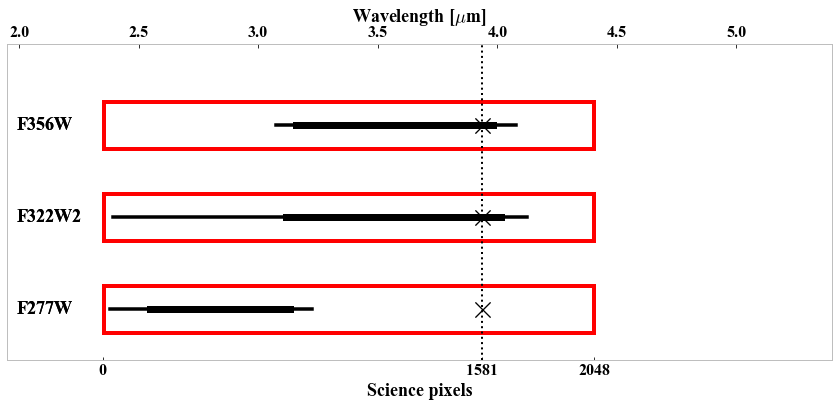

In [9]:
aspectratio =2.
figside = 12

f, ax = plt.subplots(1,figsize=(figside, figside/aspectratio))
ax2 = ax.twiny()

pixvals = np.array([0,2048])
muvals = np.arange(2.,5.01,0.5)

fac,filt,module,orient,order = facs[0],"F277W","A","R","+1"

key = '{}_{}_{}_{}_{}'.format(fac,filt,module,orient,order)
C = configs[key]
x,y = xys[filt]

ax2.set_xticks(muvals)
ax2.set_xlim(1.95,5.4)
ax.set_xlim(mutopix(ax2.get_xlim(),x,y,C,order))

xlims = ax.get_xlim()
xsize = xlims[1]-xlims[0]
ax.set_ylim(0,xsize/aspectratio)

for j,filt in enumerate(filters[:3]):
    for orient,module, order in product(orients,modules,orders):
        for k,fac in enumerate(facs):
        
            key = '{}_{}_{}_{}_{}'.format(fac,filt,module,orient,order)
            pos = positions[key] 
            x,y = xys[filt]

            yref = j*500+150
            dy = 256

            ax.plot(x, yref+dy/2, 'kx',ms=15)
            if order == '+2':
                ax.plot([pos['xstart'],pos['xend']],[yref+dy/2,yref+dy/2], 'grey', lw=7/(1+k)) 
            else:
                ax.plot([pos['xstart'],pos['xend']],[yref+dy/2,yref+dy/2], 'k', lw=7/(1+k)) 
            ax.add_patch(patches.Rectangle((4, yref),2044, dy,fill=False,color='red',lw=4))
            ax2.text(1.99,yref+dy/2, filt, va='center', fontsize=18)
            

ax.set_xlabel('Science pixels',fontsize=18)            
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=18)            
ax.axvline(x,linestyle=':',color='black')
ax.set_xticks(np.append(x,pixvals))
ax.set_facecolor('#FFFFFF')
ax2.set_facecolor('#FFFFFF')
ax.grid(False)
ax2.grid(False)

ax.axes.get_yaxis().set_visible(False)
f.tight_layout()
# # f.savefig("img1.png")

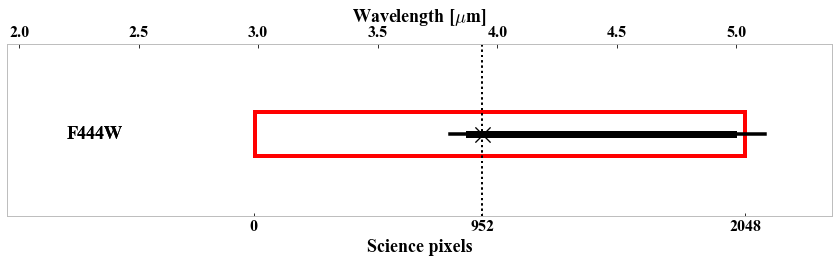

In [10]:


aspectratio = 3.
figside = 12

f, ax = plt.subplots(1,figsize=(figside, figside/aspectratio))
ax2 = ax.twiny()

pixvals = np.array([0,2048])
muvals = np.arange(2.,5.01,0.5)

filt,module,orient,order = "F444W","A","R","+1"

key = '{}_{}_{}_{}_{}'.format(fac,filt,module,orient,order)
C = configs[key]
x,y = xys[filt]

ax2.set_xticks(muvals)
ax2.set_xlim(1.95,5.4)
ax.set_xlim(mutopix(ax2.get_xlim(),x,y,C,order))

xlims = ax.get_xlim()
xsize = xlims[1]-xlims[0]
ax.set_ylim(150,xsize/aspectratio)

for j,filt in enumerate(filters[3:]):
    for orient,module, order in product(orients,modules,orders):
        for k,fac in enumerate(facs):
        
            key = '{}_{}_{}_{}_{}'.format(fac,filt,module,orient,order)
            pos = positions[key] 
            x,y = xys[filt]

            yref = j*500+500
            
            dy = 256

            ax.plot(x, yref+dy/2, 'kx',ms=15)

            ax.plot([pos['xstart'],pos['xend']],[yref+dy/2,yref+dy/2], 'k', lw=7/(1+k)) 

            ax.add_patch(patches.Rectangle((4, yref),2044, dy,fill=False,color='red',lw=4))
            ax2.text(2.2,yref+dy/2, filt, va='center', fontsize=18)

ax.axvline(x,linestyle=':',color='black')
ax.set_xticks(np.append(x,pixvals))

ax.set_xlabel('Science pixels',fontsize=18)            
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=18)            
ax.axvline(x,linestyle=':',color='black')
ax.set_xticks(np.append(x,pixvals))
ax.set_facecolor('#FFFFFF')
ax2.set_facecolor('#FFFFFF')
ax.grid(False)
ax2.grid(False)

ax.axes.get_yaxis().set_visible(False)
f.tight_layout()
# f.savefig("img1.png")

## Issues

* Need to add data to the Box directory (https://stsci.box.com/s/tf6049a75u6f3uc26q3xu6w8tv456pk7) 

## About this Notebook
**Authors:**   
* Mario Gennaro
* Dan Coe
* Alicia Canipe

**Updated On:**   
December 30, 2019